<a href="https://colab.research.google.com/github/Poseidon284/CODSOFT-Task-3/blob/main/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam SMS Classification

The goal of this notebook is to build an AI model that can classify SMS messages as spam or legitimate. Use techniques like TF-IDF or word embeddings with classifiers like Naive Bayes, Logistic Regression, or Support Vector
Machines to identify spam messages.

This notebook explores Logistic Regression and Support Vector Machines to identify the spam messages from ham messages

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Set Drive folder

In [3]:
#Choose directory of dataset
%cd '/content/gdrive/MyDrive/SpamDetection'

/content/gdrive/MyDrive/SpamDetection


In [24]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

## Data Preprocessing

In [9]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.dropna(axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Cleaning the messages

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stop = stopwords.words('english')

#Execute once to remove stop words
df['v3'] = df['v2']
df['v3'] = df['v3'].str.replace('[^\w\s]','')
pat = r'\b(?:{})\b'.format('|'.join(stop))
df['v3'] = df['v3'].str.replace(pat,'')
df['v3'] = df['v3'].str.replace(r'\s+', ' ')

df['v1']=df['v1'].replace('ham', 0)
df['v1']=df['v1'].replace('spam', 1)
labels = np.array(df['v1'])
corpus = np.array(df['v3'])
print(df['v3'])
print(corpus)
print(labels)

0       Go jurong point crazy Available bugis n great ...
1                                 Ok lar Joking wif u oni
2       Free entry 2 wkly comp win FA Cup final tkts 2...
3                     U dun say early hor U c already say
4           Nah I dont think goes usf lives around though
                              ...                        
5567    This 2nd time tried 2 contact u U å750 Pound p...
5568                    Will Ì_ b going esplanade fr home
5569                          Pity mood Soany suggestions
5570    The guy bitching I acted like id interested bu...
5571                                   Rofl Its true name
Name: v3, Length: 5572, dtype: object
['Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat'
 'Ok lar Joking wif u oni'
 'Free entry 2 wkly comp win FA Cup final tkts 21st May 2005 Text FA 87121 receive entry questionstd txt rateTCs apply 08452810075over18s'
 ... 'Pity mood Soany suggestions'
 'The guy bitching I acted like id in

<ipython-input-11-ffc3401e3ea4>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['v3'] = df['v3'].str.replace('[^\w\s]','')
<ipython-input-11-ffc3401e3ea4>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['v3'] = df['v3'].str.replace(pat,'')
<ipython-input-11-ffc3401e3ea4>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['v3'] = df['v3'].str.replace(r'\s+', ' ')


### Tokenization

In [12]:
tokens = {}
for x in corpus:
  for token in re.findall(r"\b\w\w+\b",x):
    token = token.lower()
    if token in tokens:
      tokens[token] += 1
    else:
      tokens[token] = 1
keys_tok = list(tokens.keys())
for x in keys_tok:
  if tokens[x] <= 2:
    del tokens[x]

In [13]:
tokens = sorted(tokens.items(),key=lambda x:x[1],reverse=True)
tokens = dict(tokens)
str1 = ""
str1 = ' '.join(list(tokens.keys()))
print(str1)

call im get ur you dont go ok ltgt free know like got ill good come time day love want send text no going one need txt home lor see sorry still back stop how reply if today but mobile tell new later well think da hi so please just take its phone we my the cant do ì_ your week claim much night oh what great hey and dear pls happy hope make way work give wat have thats number prize to right this say now already are tomorrow ask can yes really yeah said message amp is msg didnt meet babe last morning life miss it would cos ive cash thanks lol anything find every win sure pick also let nokia something contact sent keep care urgent not buy us next feel first around even went thing then could soon tonight wait place someone service many per friends customer gonna nice money in always late me chat ya sleep dun help leave wan wont did for he waiting youre things gud told ìï wish 16 getting year guaranteed when yet people thk coming done hello that try haha tone name thought friend may live hav

### Word Cloud Visualization

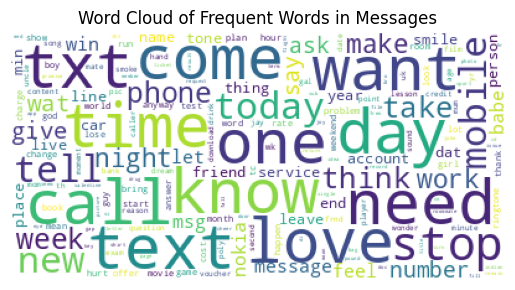

In [14]:
# wordcloud = WordCloud().generate(str1)
wordcloud = WordCloud(background_color="white",max_words=len(str1),max_font_size=50, relative_scaling=.5).generate(str1)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud of Frequent Words in Messages")
plt.show()

In [15]:
df.head()

,v1,v2,v3
0,0,"Go until jurong point, crazy.. Available only ...",Go jurong point crazy Available bugis n great ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,U dun say early hor U c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think goes usf lives around though


## Train Test Split

In [18]:
X = df['v3']
Y = df['v1']

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=120)
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(x_train)
test_feature = tfidf.transform(x_test)

## SVM Model

In [19]:
svm_model = svm.SVC()
svm_model.fit(feature,y_train)
y_pred = svm_model.predict(test_feature)


print("Accuracy of SVM model : ",accuracy_score(y_test,y_pred))
print("Confusion Matrix : \n",confusion_matrix(y_test,y_pred))
print("Classification Report : \n",classification_report(y_test,y_pred))

Accuracy of SVM model :  0.9766816143497757
Confusion Matrix : 
 [[951   1]
 [ 25 138]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       952
           1       0.99      0.85      0.91       163

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix Visualization for Model

<Axes: title={'center': 'Spam Detection(ham - 0, spam - 1)'}>

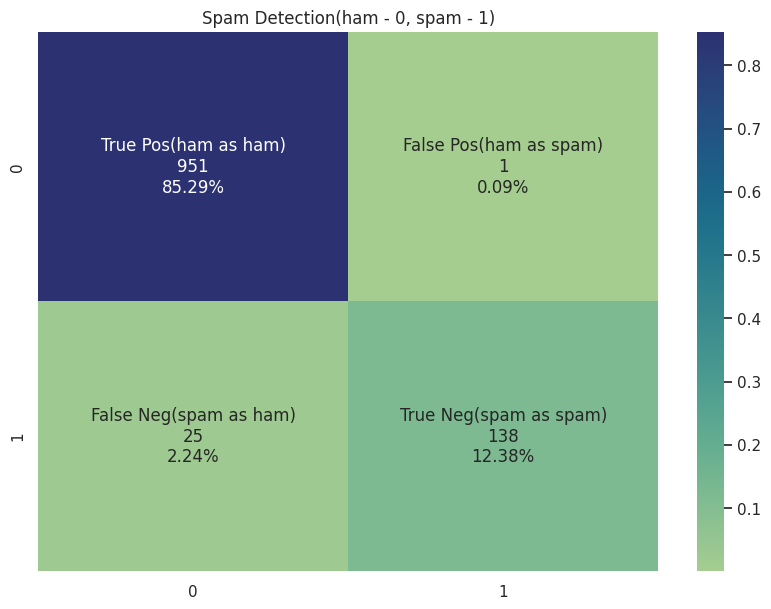

In [38]:
conf_mat = confusion_matrix(y_test,y_pred)
group_names = ['True Pos(ham as ham)','False Pos(ham as spam)','False Neg(spam as ham)','True Neg(spam as spam)']
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
group_percent = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_names,group_counts,group_percent)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(10,7)})
ax = plt.axes()
ax.set_title('Spam Detection(ham - 0, spam - 1)')
sns.heatmap(conf_mat/np.sum(conf_mat),annot=labels,fmt='',ax =ax,cmap="crest")

### SVM Hyperparameter Tuning

GridSearchCV is used to select the best hyperparameters for the SVM model

In [21]:
tuned_parameters = {
    'kernel' : ['linear','rbf'],
    'gamma' : [1e-2,1e-3,1e-4],
    'C' : [1,10,100,1000]
}

svm_hypo = GridSearchCV(svm.SVC(),tuned_parameters)
svm_hypo.fit(feature,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

### Confusion Matrix Visualization

In [23]:
y_hypo_predict = svm_hypo.predict(test_feature)

print("Hyperparameter Tuned Model")
print("Accuracy of SVM model : ",accuracy_score(y_test,y_hypo_predict))
print("Confusion Matrix : \n",confusion_matrix(y_test,y_hypo_predict))
print("Classification Report : \n",classification_report(y_test,y_hypo_predict))

Hyperparameter Tuned Model
Accuracy of SVM model :  0.9856502242152466
Confusion Matrix : 
 [[949   3]
 [ 13 150]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       952
           1       0.98      0.92      0.95       163

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



<Axes: title={'center': 'Spam Detection(ham - 0, spam - 1)'}>

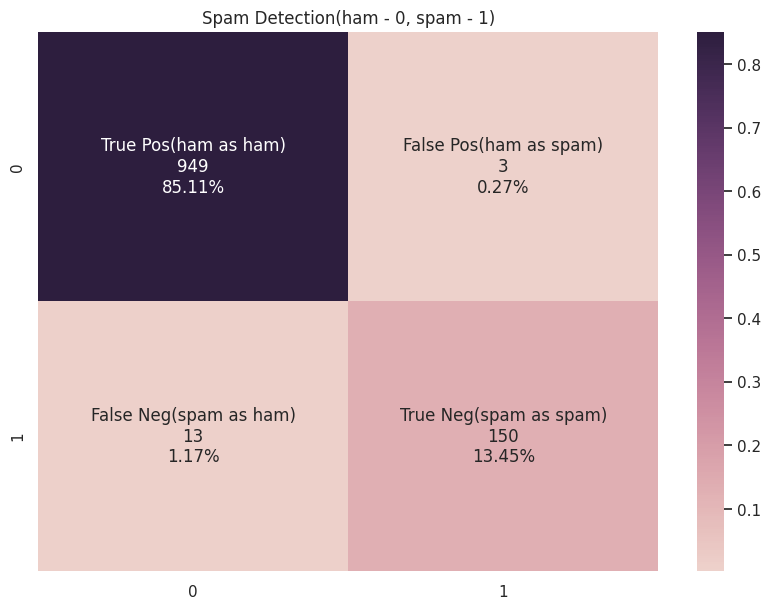

In [39]:
conf_mat = confusion_matrix(y_test,y_hypo_predict)
group_names = ['True Pos(ham as ham)','False Pos(ham as spam)','False Neg(spam as ham)','True Neg(spam as spam)']
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
group_percent = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_names,group_counts,group_percent)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(10,7)})
ax = plt.axes()
ax.set_title('Spam Detection(ham - 0, spam - 1)')
sns.heatmap(conf_mat/np.sum(conf_mat),annot=labels,fmt='',ax =ax,cmap=sns.cubehelix_palette(as_cmap=True))

## Accuracy Difference after Hyperparameter Tuning

The GradientCV method used for the hyperparameter tuning yielded an increased precision in predicting spam messages correctly. (138/163 -> 150/163)

Moreover, the overall accuracy of the model increased by **0.9%**

In [59]:
accuracy_base = accuracy_score(y_test,y_pred)
accuracy_hypo = accuracy_score(y_test,y_hypo_predict)
print(f"Difference in Accuracy of HyperFitting : {accuracy_hypo-accuracy_base:.2%}")

Difference in Accuracy of HyperFitting : 0.90%


## Author

Radhesh Rathnam J

Feb 8, 2023